In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import warnings
from sklearn.model_selection import train_test_split

In [4]:
# Data Preparation (TSLA only)
warnings.filterwarnings("ignore")

# Download TSLA data only
tsla_data = yf.download("TSLA", start="2022-01-01", end="2025-01-01", progress=False)

# Keep only closing prices
tsla_data = tsla_data[['Close']]
tsla_data.columns = ['Tsla']

# Handle missing values
tsla_data.fillna(method='ffill', inplace=True)

# Normalize data
scaler = MinMaxScaler()
tsla_data['Tsla_scaled'] = scaler.fit_transform(tsla_data[['Tsla']])

# Sequence length for input data
sequence_length = 30

# Function to create sequences (TSLA only)
def create_sequences(data, seq_length):
    sequences, targets = [], []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])  # 30 days of TSLA prices
        targets.append(data[i + seq_length])  # Predict the next day's TSLA price

    return np.array(sequences), np.array(targets)

# Prepare input-output data
X, y = create_sequences(tsla_data[['Tsla_scaled']].values, sequence_length)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)  # Should be (samples, 30, 1) for transformer input


YF.download() has changed argument auto_adjust default to True
(578, 30, 1)


In [5]:
# Positional Encoding Function (Remains the Same)
def positional_encoding(seq_length, d_model):
    pos = np.arange(seq_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # Apply sin to even indices, cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(angle_rads, dtype=tf.float32)

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.depth = embed_dim // num_heads

        self.wq = Dense(embed_dim)
        self.wk = Dense(embed_dim)
        self.wv = Dense(embed_dim)
        self.dense = Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = tf.reshape(q, (batch_size, -1, self.num_heads, self.depth))
        k = tf.reshape(k, (batch_size, -1, self.num_heads, self.depth))
        v = tf.reshape(v, (batch_size, -1, self.num_heads, self.depth))

        attention_scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.reshape(output, (batch_size, -1, self.embed_dim))
        return self.dense(output)

# Transformer Encoder Block
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.attention(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

# Build Transformer Model for TSLA Prediction
def build_transformer_model(input_shape, embed_dim=64, num_heads=4, ff_dim=128):
    inputs = keras.Input(shape=input_shape)

    # Positional Encoding
    positions = positional_encoding(input_shape[0], embed_dim)
    x = Dense(embed_dim)(inputs) + positions

    # Transformer Encoder Layers
    x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
    x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    # Global Average Pooling to Reduce Sequence Dimension
    x = keras.layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
    return model


In [6]:
# Define Transformer Model
transformer_model = build_transformer_model(X_train.shape[1:])

# Early Stopping Callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)



Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.3051 - val_loss: 0.0615
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0283 - val_loss: 0.0338
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0184 - val_loss: 0.0468
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0165 - val_loss: 0.0482
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0144 - val_loss: 0.0154
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0141 - val_loss: 0.0117
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0144 - val_loss: 0.0229
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0095 - val_loss: 0.0151
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0086 - val_loss: 0.0131
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0079 - val_loss: 0.0133
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0077 - val_loss: 0.0107
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.

In [8]:
# Define an LSTM Model
def build_lstm_model(input_shape):
    model = keras.Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
    return model

# Create LSTM model
lstm_model = build_lstm_model(X_train.shape[1:])

# Train LSTM model
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Make predictions with both models
y_pred_transformer = transformer_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)

# Convert predictions back to actual stock prices
y_pred_transformer_actual = scaler.inverse_transform(np.column_stack((y_pred_transformer, np.zeros_like(y_pred_transformer))))[:, 0]
y_pred_lstm_actual = scaler.inverse_transform(np.column_stack((y_pred_lstm, np.zeros_like(y_pred_lstm))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]



Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0448 - val_loss: 0.0231
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0118
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - val_loss: 0.0095
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038 - val_loss: 0.0065
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0082
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

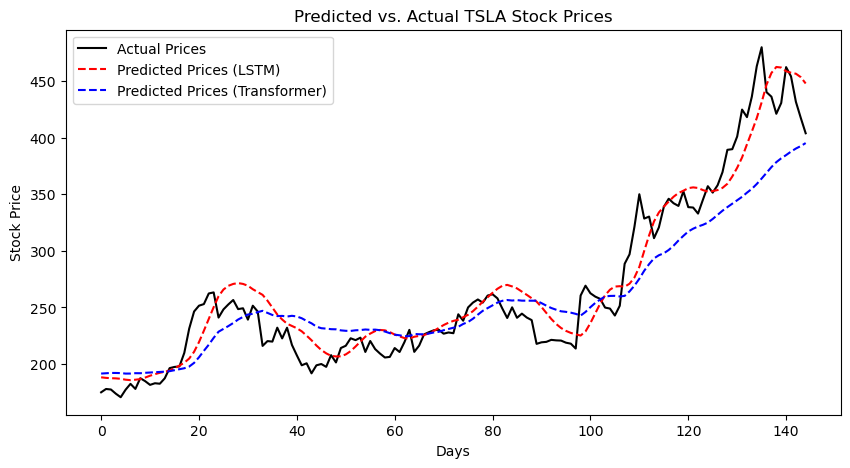

In [11]:
plt.figure(figsize=(10, 5))

# Plot actual stock prices
plt.plot(y_test_actual, label="Actual Prices", color="black")

# Plot LSTM predictions
plt.plot(y_pred_lstm_actual, label="Predicted Prices (LSTM)", linestyle="dashed", color="red")

# Plot Transformer predictions
plt.plot(y_pred_transformer_actual, label="Predicted Prices (Transformer)", linestyle="dashed", color="blue")

# Add labels and legend
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Predicted vs. Actual TSLA Stock Prices")
plt.legend()
plt.show()
